In [1]:
# gen graph
import numpy as np
import graphlearning as gl
import matplotlib.pyplot as plt
import sys
from torch_geometric.data import Data

seed=0
size = 10
n=20000
eps = 0.05

np.random.seed(seed)
X = gl.utils.rand_ball(n,2)
Wc = gl.weightmatrix.epsilon_ball(X,eps,kernel='uniform')
if not gl.graph(Wc).isconnected():
    sys.exit('Graph is not connected')
bdy = np.linalg.norm(X,axis=1) > 1-eps

In [2]:
# convert to torch_geo
from torch_geometric.utils import from_scipy_sparse_matrix, remove_self_loops, to_undirected
e_i, e_a = from_scipy_sparse_matrix(Wc)
e_i, e_a = remove_self_loops(e_i,e_a)

graph = Data(edge_index = e_i, edge_attr= e_a)
import torch
graph.train_mask = torch.from_numpy(~bdy)
graph.init_distances = graph.train_mask.to(torch.float)
graph.init_distances = graph.init_distances.view(-1,1)
graph.train_mask = graph.train_mask.view(-1,1)
print(graph.edge_index.shape)
print(graph.edge_attr.shape)

# add 1k random edges
edge_index_to_add = torch.randint(0, n, (2, 1000), dtype=torch.long)
edge_index_to_add = to_undirected(edge_index_to_add)
edge_attr_to_add = torch.ones(edge_index_to_add.shape[1]).to(torch.float)
graph.edge_index = torch.cat([graph.edge_index, edge_index_to_add], dim=1)
graph.edge_attr = torch.cat([graph.edge_attr, edge_attr_to_add],dim=0)
print(graph.edge_index.shape)
print(graph.edge_attr.shape)

torch.Size([2, 975672])
torch.Size([975672])
torch.Size([2, 977672])
torch.Size([977672])


In [3]:
graph = graph.to("cuda:0")
# run eikonal p=1 eikonal equation
t = (torch.linspace(0,200.0,2)).to("cuda:0")
from pde2 import Net
with torch.no_grad():
    model = Net(graph, graph.train_mask, graph.init_distances, 0.5, t, "cuda:0")
    new_sig = model(graph.init_distances)

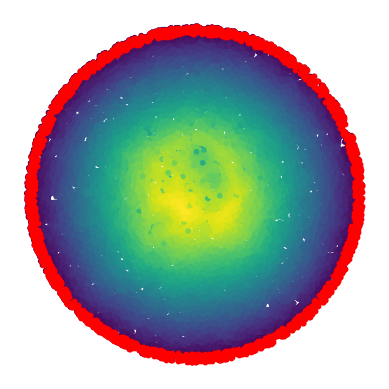

In [4]:
out = new_sig.view(-1,).cpu().numpy()
plt.figure()
plt.scatter(X[:,0],X[:,1], s=size, c=out)
plt.scatter(X[bdy,0],X[bdy,1], s=size, c='red')
plt.axis('off')
plt.axis('square')
plt.savefig("p_1_1000.png")
plt.show()

In [5]:
#run shortest-path p=\infty eikonal equation
from pde3 import Net as Net2
t2 = (torch.linspace(0,200.0,2)).to("cuda:0")
with torch.no_grad():
    model = Net2(graph, graph.train_mask, graph.init_distances, 0.5, t, "cuda:0")
    new_sig2 = model(graph.init_distances)

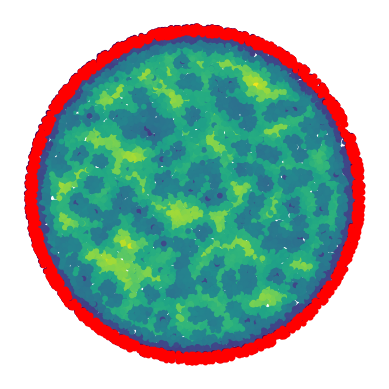

In [6]:
out2 = new_sig2.view(-1,).cpu().numpy()
plt.figure()
plt.scatter(X[:,0],X[:,1], s=size, c=out2)
plt.scatter(X[bdy,0],X[bdy,1], s=size, c='red')
plt.axis('off')
plt.axis('square')
plt.savefig("p_inf_1000.png")
plt.show()